# Trying to train a reinforcement learning agent to maximize area coverage by a swarm of drones

# --------------------------------------------------------------

# --------------------------------------------------------------

## Defining the environment

In [69]:
import numpy as np
import torch
import random
from collections import deque

class Swarm:
    def __init__(self, n_drones, grid_size, init_state):
        self.n_drones = n_drones
        self.positions = []
        self.state = init_state
        pos = 0
        for i in range(len(init_state[0])):
            if init_state[0][i] == 2:
                # row = i // grid_size[0]
                # col = i % grid_size[0]
                self.positions.append(i)
        self.grid_size = grid_size
        self.state_size = self.grid_size[0] * self.grid_size[1]
        self.action_size = self.n_drones
        self.coverage_area = set()

    def step(self, actions):
        rewards = torch.zeros(self.n_drones)
        
        cur_state = self.state.clone()
        # print("Taking step:")
        for i, action in enumerate(actions):
            # action = torch.argmax(act, dim=1)
            pos = self.positions[i]
            row = pos // self.grid_size[1]
            col = pos % self.grid_size[1]
            # print(self.state[0][pos], pos, self.positions)
            cur_state[0][pos] = max(cur_state[0][pos] - 2, 1)  # covered
            row_old, col_old = row, col
            if action == 0: # move up
                row = max(0, row - 1)
            elif action == 1: # move down
                row = min(self.grid_size[0] - 1, row + 1)
            elif action == 2: # move left
                col = max(0, col - 1)
            elif action == 3: # move right
                col = min(self.grid_size[1] - 1, col + 1)
            self.positions[i] = row*self.grid_size[1] + col
            if cur_state[0][self.positions[i]] == 1:
                cur_state[0][self.positions[i]] = 2
            else:
                cur_state[0][self.positions[i]] += 2
            if self.positions[i] not in self.coverage_area:
                self.coverage_area.add(self.positions[i])
                rewards[i] = 1
            if row == row_old and col == col_old:
                rewards[i] = -1
                # print(f"Unchanged {row}, {col}, Action: {action}")
                # print(row*self.grid_size[1] + col)
        self.state = cur_state
        done = len(self.coverage_area) == self.state_size
        return rewards, done
    
    def get_state(self):
        return self.state
    
    def reset(self, init_state):
        self.state = init_state
        self.coverage_area = set()
        self.positions = []
        pos = 0
        for i in range(len(init_state[0])):
            if init_state[0][i] == 2:
                # row = i // grid_size[0]
                # col = i % grid_size[0]
                self.positions.append(i)


## The policy network (we're using on-policy learning)

In [70]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    def __init__(self, n_drones, state_size, action_size):
        super().__init__()
        self.n_drones = n_drones
        self.x1 = nn.Linear(state_size, 64)
        self.x2 = nn.Linear(64, 32)
        self.x3 = nn.Linear(32, 32)
        self.x4 = nn.Linear(32, action_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
    def forward(self, state):
        op = self.x1(state)
        op = self.relu(op)
        op = self.x2(op)
        op = self.relu(op)
        op = self.x3(op)
        op = self.relu(op)
        op = self.x4(op)
        op = self.softmax(op)
        outputs = []
        for i in range(self.n_drones):
            outputs.append(op)
        return outputs

## The agent

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

all_states = []

class DQNAgent:
    def __init__(self, n_drones, state_size, action_size, model, learning_rate=0.001, discount_factor=0.95, batch_size=32, memory_size=10000):
        self.n_drones = n_drones
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        # self.model = self.build_model()
        self.model = model
        

    def build_model(self):
        
        model = tf.keras.Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size * self.n_drones, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        act_values = self.model(state)
        # if np.random.rand() <= self.epsilon:
        #    return
        act_values = [Categorical(act) for act in act_values]
        
        return act_values
    
    def plot_state(self, state, nrows, ncols):
        for i in range(nrows):
            for j in range(ncols):
                print(f"{state[0][i*ncols+j]}", end=" | ")
            print("\n" + "-"*60)
        print("Pure state: ", state)
        print("\n\n\n\n\n")

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.zeros((self.batch_size, self.state_size))
        actions = np.zeros((self.batch_size, self.n_drones), dtype=int)
        rewards = np.zeros((self.batch_size, self.n_drones))
        next_states = np.zeros((self.batch_size, self.state_size))
        dones = np.zeros((self.batch_size,))
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            actions[i] = action
            rewards[i] = reward
            next_states[i] = next_state
            dones[i] = done
            
        
        targets = self.model.predict(states)
        q_next = self.model.predict(next_states)
        for i in range(self.batch_size):
            for j in range(self.n_drones):
                if dones[i]:
                    targets[i][j] = rewards[i][j]
                else:
                    targets[i][j] = rewards[i][j] + self.discount_factor * np.max(q_next[i][j])
                    print(f"Done with {i}, {j}")
        self.model.fit(states, targets, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, env, n_episodes):
        torch.autograd.set_detect_anomaly(True)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        for i_episode in range(n_episodes):
            state = torch.zeros((1, self.state_size))
            init_indices = np.random.choice(len(state[0]), size=self.n_drones, replace=False)
            state[0][init_indices] = 2  # initial positions of the drones
            # state = state  # creates a new state object and points it to the 
            env.reset(state)
            done = False
            total_reward = 0
            timestep = 0
            all_states.append([])
            while not done and timestep < 1000:
                actions = self.act(env.get_state())
                # act_values = [torch.argmax(ac, dim=1) for ac in actions]
                act_values = [act.sample() for act in actions]
                rewards, done = env.step(act_values)
                
                loss = [actions[i].log_prob(act_values[i])*(rewards[i]+ (1e-2)) for i in range(self.n_drones)]
                loss = -1 * sum(loss)
                
                # filter the logits, those that gave reward 1 should prevail. others set to 0
                # loss = [actions[i] * abs(1 - rewards[i]) for i in range(self.n_drones)]
                # loss = torch.stack(loss)
                # print(f"Loss shape: {loss.shape}\nActions shape: {actions[0].shape}")
                # loss = torch.sum(loss, dim=2)
                # loss = torch.sum(loss, dim=0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_reward = len(env.coverage_area)
                
                # state = next_state
                if (timestep % 100 == 0 or timestep % 100 == 1):
                    print(f"Timestep: {timestep}, Rewards: {total_reward}")
                    self.plot_state(env.get_state(), 10, 10)
                    
                all_states[-1].append(np.reshape(env.get_state(), env.grid_size))
                timestep += 1
                writer.add_scalar(f'Reward progression {i_episode}', total_reward, timestep)
                # next_state = np.array([len(env.coverage_area) / (env.grid_size[0] * env.grid_size[1])])
                # self.remember(state, actions, rewards, next_state, done)
                # self.replay()
            print("Episode {}/{}, Total Reward: {}, Epsilon: {:.2}, Timesteps: {}"
                  .format(i_episode + 1, n_episodes, total_reward, self.epsilon, timestep))
            self.plot_state(env.get_state(), 10, 10)


## Let it rip

In [72]:
n_drones = 10
grid_size = (10, 10)
state_size = grid_size[0] * grid_size[1]
action_size = 4
state = torch.zeros((1, state_size))
init_indices = np.random.choice(len(state[0]), size=n_drones, replace=False)
state[0][init_indices] = 2  # initial positions of the drones
env = Swarm(n_drones=n_drones, grid_size=grid_size, init_state=state)
model = PolicyNetwork(n_drones, state_size=state_size, action_size=action_size)
agent = DQNAgent(n_drones=10, state_size=state_size, action_size=action_size, model=model)
agent.learn(env, n_episodes=100)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Timestep: 0, Rewards: 10
0.0 | 2.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 2.0 | 0.0 | 0.0 | 
------------------------------------------------------------
0.0 | 1.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
------------------------------------------------------------
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 1.0 | 2.0 | 0.0 | 2.0 | 1.0 | 
------------------------------------------------------------
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 1.0 | 
------------------------------------------------------------
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 2.0 | 
------------------------------------------------------------
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
------------------------------------------------------------
0.0 | 0.0 | 0.0 | 2.0 | 2.0 | 1.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
------------------------------------------------------------
0.0 | 0.0 | 0.0 | 1.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
------------------------------------------------------------

KeyboardInterrupt: 

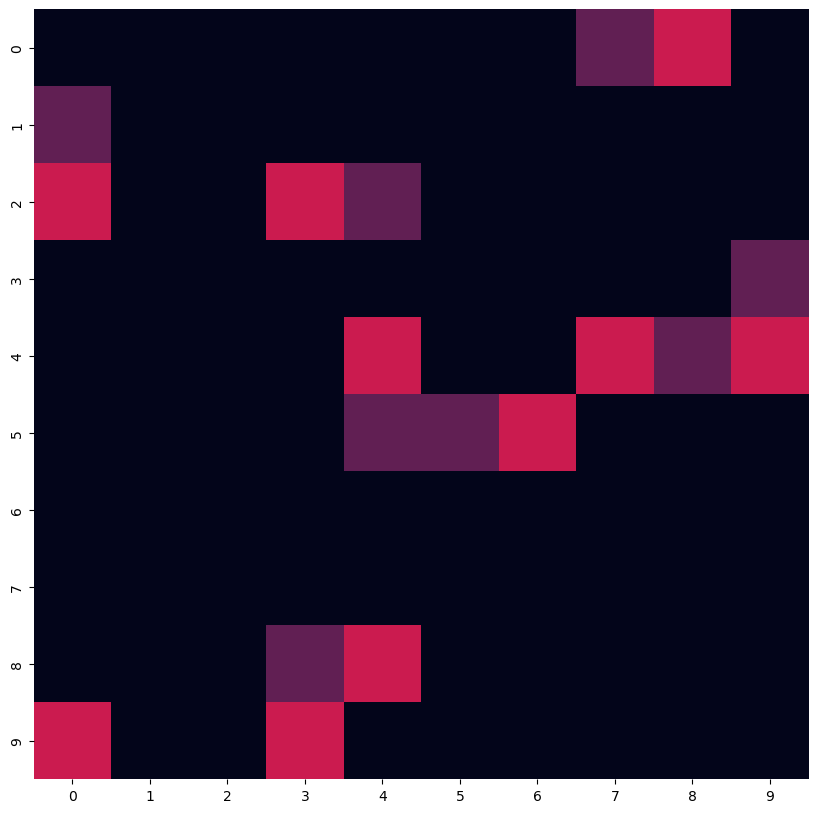

In [84]:
import seaborn as sns
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
def animate(data):
    ax = sns.heatmap(data, vmin=0, vmax=4, cbar=False)
    return ax
    
ani = FuncAnimation(fig, animate, frames=all_states[1], interval=100)
ani.save('myAnimation1.gif', writer='imagemagick', fps=10)